In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from foodwebs.foodweb import FoodWeb
from foodwebs.foodweb_io import readFW_SCOR
from foodwebs.normalization import flows_normalization
import networkx as nx

import plotly.graph_objects as go
import matplotlib.pyplot as pltś
import pylab

from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [255]:
class FoodWeb:
    '''Class defining a food web of an ecosystem with given stock biomasses
    and flows between species (compartments)"
    '''

    def __init__(self, title='Empty title', nodeDF=None, flowMatrix=None):
        '''Constructor from given dataframes'''
        self.title = title

        # a dataframe with columns:
        # "Name", "IsLiving", "Biomass", "Import", "Export", "TrophicLevel", "Respiration"
        self.nodeDF = nodeDF

        # a dataframe of system flows within the ecosystem
        self.flowMatrix = flowMatrix

        # number of nodes
        self.n = len(self.nodeDF.index)

        # number of living nodes
        self.n_living = len(self.nodeDF[self.nodeDF.IsLiving == True].index)

        self.graph = nx.from_pandas_adjacency(self.getFlowMatWithBoundary(),  create_using=nx.DiGraph)
        
        # we can calculate trophic levels
        if len(flowMatrix) > 1:
            self.nodeDF['TrophicLevel'] = self.calcTrophicLevels()

        self.nodeDF = self.nodeDF.set_index(nodeDF["Names"])
 
    def getGraph(self, boundary=False):
        exclude_nodes = [] if boundary else ['Import', 'Export', 'Respiration']
        
        exclude_edges = []
        for n in self.nodeDF.Names.values:
            exclude_edges.append(('Import', n))
            exclude_edges.append((n, 'Export'))
            exclude_edges.append((n, 'Respiration'))
        return nx.restricted_view(self.graph, exclude_nodes, exclude_edges)
        
    def getFlows(self, boundary=False, mark_alive_nodes=True):
        '''Function returns a long dataframe of all internal flows'''
        graph = self.getGraph(boundary)

        if mark_alive_nodes:
            graph = nx.relabel_nodes(graph, self._is_alive_mapping())
        return graph.edges(data=True)
    
    def getFlowMatWithBoundary(self):
        '''Returns the flow matrix including the boundary flows as the last row and column'''
        flowMatrixWithBoundary = self.flowMatrix.copy()
        flowMatrixWithBoundary.loc['Import'] = x.nodeDF.Import.to_dict()
        flowMatrixWithBoundary.loc['Export'] = x.nodeDF.Export.to_dict()
        flowMatrixWithBoundary.loc['Respiration'] = x.nodeDF.Respiration.to_dict()
        return (
            flowMatrixWithBoundary
            .join(x.nodeDF.Import)
            .join(x.nodeDF.Export)
            .join(x.nodeDF.Respiration)
            .fillna(0.0)
        )

    def getLinksNr(self):
        '''Returns the number of nonzero system links'''
        return self.getGraph(False).number_of_edges()
    
    def getFlowSum(self):
        "Returns the sum of ALL flows"
        return self.getFlowMatWithBoundary().sum()
    
    def _is_alive_mapping(self):
        '''
        Creates dictionary which special X character to names, which are not alive
        '''
        return {name: f'\u2717 {name}' for name in self.nodeDF[x.nodeDF.IsAlive == False].Names.values}


    
    
    
    def writeXLS(self, filename):
        '''Save the FoodWeb as an XLS file - spreadsheets.'''
        print(f'Saving FoodWeb with title {self.title}')
        writer = pd.ExcelWriter(filename)

        # save title
        pd.DataFrame([self.title]).to_excel(writer, sheet_name="Title")

        # save nodes DataFrame
        self.nodeDF.to_excel(writer, sheet_name="Node properties")

        # save flow matrix
        self.flowMatrix.to_excel(writer, sheet_name="Internal flows")
        writer.save()

    def getNormInternFlows(self):
        '''Function returning a list of internal flows normalized to TST'''
        flows = find_edges(self.flowMatrix, False)
        TST = sum(link[2] for link in flows)
        return [x[2] / TST for x in flows]

    def getNormNodeProp(self):
        numNodeProp = self.nodeDF.loc[:, [
            "Biomass", "Import", "Export", "Respiration"]]
        return(numNodeProp.div(numNodeProp.sum(axis=0), axis=1))


    def wrsep(self, filename):  # add the separating -1 to the SCOR file
        with open(filename, 'a') as f:
            f.write('-1 \n')

    def write_SCOR(self, filename):
        # function writing the current food web ('self') to a SCOR file
        with open(filename, 'w') as f:
            f.write(self.title + ' \n')  # save the title of the network
            # number of compartments
            f.write(str(self.n)+' '+str(self.n_living)+' \n')
            for s in self.names:  # names of the species/compartments
                f.write(str(s) + ' \n')

        self.idNr(self.nodeDF.loc[:, "Biomass"]).to_csv(
            filename, header=None,  sep=' ', mode='a')  # save the nodeDF.loc[:,"Biomass"]
        self.wrsep(filename)
        infl = self.idNr(self.nodeDF.loc[:, "Import"])  # save the imports
        infl.to_csv(filename, header=None, sep=' ', mode='a')
        self.wrsep(filename)
        outfl = self.idNr(self.nodeDF.loc[:, "Export"])  # save the exports
        outfl.to_csv(filename, header=None, sep=' ', mode='a')
        self.wrsep(filename)
        self.idNr(self.nodeDF.loc[:, "Respiration"]).to_csv(
            filename, header=None,  sep=' ', mode='a')
        self.wrsep(filename)

        with open(filename, 'a') as f:
            # write the internal flows as edges list
            edgList = find_edges(self.flowMatrix, False)

            for edge in edgList:
                for x in edge:
                    f.write(str(x)+' ')
                f.write('\n')
        self.wrsep(filename)

    def calcTrophicLevels(self):
        '''function calculating the trophic levels of nodes from the recursive relation'''
        dataSize = len(self.flowMatrix)
        A = np.zeros([dataSize, dataSize])
        inflow = np.zeros(dataSize)
        isFixedToOne = np.zeros(dataSize, dtype=bool)
        dataTrophicLevel = np.zeros(dataSize)

        n = 0  # counting the nodes with TL fixed to 1
        for i in range(0, dataSize):
            isFixedToOne[i] = False
            dataTrophicLevel[i] = 0.0
            for j in range(0, dataSize):
                # sum of all incoming system flows to the compartment i
                inflow[i] += self.flowMatrix.iloc[j, i]
                # the diagonal has the sum of all incoming system flows to the compartment i,
                # except flow from i to i
                A[i][i] += self.flowMatrix.iloc[j, i]
                if i != j:
                    A[i][j] = -self.flowMatrix.iloc[j, i]

            # choose the nodes that have TL=1: non-living and primary producers == inflows equal to zero
            if (inflow[i] <= 0.0 or i >= int(self.n_living)):
                isFixedToOne[i] = True
                dataTrophicLevel[i] = 1.0
                n += 1

        if (n != 0):
            # update the equation due to the prescribed trophic level 1 - reduce the dimension of the matrix
            B_tmp = np.zeros(dataSize - n)
            A_tmp = np.zeros([dataSize - n, dataSize - n])
            TL_tmp = np.zeros(dataSize - n)
            tmp_i = 0
            for i in range(0, dataSize):
                if not isFixedToOne[i]:
                    B_tmp[tmp_i] = inflow[i]
                    tmp_j = 0
                    for j in range(0, dataSize):
                        if (isFixedToOne[j]):  # means also i!=j
                            # moving the contribution to the constant part,
                            # + flow(j->i)*1 to both sides of the equation
                            B_tmp[tmp_i] -= A[i][j]
                        else:
                            A_tmp[tmp_i][tmp_j] = A[i][j]
                            tmp_j += 1
                    tmp_i += 1

            for i in range(0, dataSize-n):
                TL_tmp[i] = 0.0
                Ainverse = np.linalg.pinv(A_tmp)
                for j in range(0, dataSize-n):

                    TL_tmp[i] += Ainverse[i][j] * B_tmp[j]

            k = 0
            for i in range(0, dataSize):
                if (not isFixedToOne[i]):
                    dataTrophicLevel[i] = TL_tmp[k]
                    k += 1
        else:
            try:
                A1 = np.linalg.pinv(A)
            except:
                # negative trophic levels signify some problems
                # print("The matrix A1 which inverse was seeked but does not exist:")
                print(A1)
        return dataTrophicLevel

    def __str__(self):
        '''Overloading print operator'''
        return f'''
                {self.title}\n
                {self.nodeDF.loc[:,"Biomass"]}\n
                {self.nodeDF.loc[:,"Biomass"]}\n
                The internal flows matrix: a_ij=flow from i to j\n
                {self.flowMatrix}\n'
                {self.nodeDF.loc[:,"Import"]}\n
                {self.nodeDF.loc[:,"Export"]}\n
                {self.nodeDF.loc[:,"Respiration"]}\n
                {self.nodeDF.loc[:,"TrophicLevel"]}\n
                '''

In [238]:
def readFW_SCOR(scor_path):
    '''
    Reads a TXT file in the SCOR format and returns a FoodWeb object

      SCOR file:
      -------------------------------------------------------------
      title
      #of all compartments #of living compartments
      1st compartment name
      2nd compartment name
      ...
      biomasses (stock)  // line -> vector element
      -1
      imports (B^in)
      -1
      exports (B^out)
      -1
      respiration (R)
      -1
      flows ((Victoria's S)^T)  // line -> matrix element
      -1 -1
      ----------------------------------------------------------
    '''
    with open(scor_path, 'r', encoding='utf-8') as f:
        title = f.readline().strip()
        size = f.readline().split()
        assert len(size) == 2
        n = int(size[0])
        n_living = int(size[1])

        lines = [x.strip() for x in f.readlines()]

        net = pd.DataFrame(index=range(1, n+1))
        net['Names'] = lines[:n]
        net['IsAlive'] = [i < n_living for i in range(n)]

        for i, col in enumerate(['Biomass', 'Import', 'Export', 'Respiration']):
            net[col] = [float(x.split(' ')[1])
                        for x in lines[(i + 1) * n + i: (i + 2) * n + i]]

        flowMatrix = pd.DataFrame(index=range(1, n+1), columns=range(1, n+1))
        for line in [x.split(' ') for x in lines[(i + 2) * n + i + 1: -1]]:
            flowMatrix.at[int(line[0]), int(line[1])] = float(line[2])
        flowMatrix = flowMatrix.fillna(0.0)
        flowMatrix.index = net.Names
        flowMatrix.columns = net.Names

        return FoodWebX(title=title, flowMatrix=flowMatrix,
                       n=n, n_living=n_living, nodeDF=net)

In [239]:
import glob
food_webs = [readFW_SCOR(net_path) for net_path in glob.glob('./data/*')]

for web in food_webs:
    print(f'{web.title[:30]} --> {web.n}, {web.n_living}')
    web.nodeDF['trophic'] = round(web.nodeDF.TrophicLevel)

Upper Chesapeake Bay in Summer --> 34, 28
Albatross Bay _ 465 ,   bay/fj --> 99, 92
USA, Mid Atlantic Bight _ 99 , --> 55, 54
Flow network of St Marks febs2 --> 51, 40
Table 9. Flow data for the Thu --> 33, 29
Alaska, Prince William Sound _ --> 19, 18
"Mdloti Network, March 2003, i --> 46, 43
Bothnian Bay; Sandbert, et al. --> 12, 10
FLORIDA BAY TROPHIC EXCHANGE M --> 125, 104
Oneida Post ZM Unbalanced      --> 76, 73
Bay of Biscay _ 335 ,   contin --> 32, 30


In [240]:
x = food_webs[0]

In [228]:
x.graph.nodes()

NodeView(('Net Phytoplankton', 'Weakfish', 'Bluefish', 'Striped Bass', 'Catfish', 'American Eel', 'Hogchoker', 'Croaker', 'Spot', 'White Perch', 'Herrings and Shads', 'Bay anchovy', 'Menhaden', 'Blue Crab', 'Suspension Feeding Benthos', 'Meiofauna', 'Picoplankton', 'Free Bacteria', 'Particle Attached Bacteria', 'Heteroflagellates', 'Ciliates', 'Deposit Feeding Benthos', 'Meroplankton', 'Rotifers', 'Ctenophores', 'Microphytobenthos', 'Benthic Bacteria', 'Mesozooplankton', 'Chrysaora', 'SAV', 'POC', 'DOC', 'Sediment POC', 'Oysters', 'Import', 'Export', 'Respiration'))

In [229]:
x.graph.edges()

OutEdgeView([('Net Phytoplankton', 'Menhaden'), ('Net Phytoplankton', 'Suspension Feeding Benthos'), ('Net Phytoplankton', 'Ciliates'), ('Net Phytoplankton', 'Meroplankton'), ('Net Phytoplankton', 'Rotifers'), ('Net Phytoplankton', 'Mesozooplankton'), ('Net Phytoplankton', 'POC'), ('Net Phytoplankton', 'DOC'), ('Net Phytoplankton', 'Sediment POC'), ('Net Phytoplankton', 'Import'), ('Net Phytoplankton', 'Respiration'), ('Weakfish', 'POC'), ('Weakfish', 'DOC'), ('Weakfish', 'Export'), ('Weakfish', 'Respiration'), ('Bluefish', 'POC'), ('Bluefish', 'DOC'), ('Bluefish', 'Export'), ('Bluefish', 'Respiration'), ('Striped Bass', 'POC'), ('Striped Bass', 'DOC'), ('Striped Bass', 'Export'), ('Striped Bass', 'Respiration'), ('Catfish', 'POC'), ('Catfish', 'DOC'), ('Catfish', 'Export'), ('Catfish', 'Respiration'), ('American Eel', 'POC'), ('American Eel', 'DOC'), ('American Eel', 'Import'), ('American Eel', 'Export'), ('American Eel', 'Respiration'), ('Hogchoker', 'Weakfish'), ('Hogchoker', 'Strip

In [129]:
len(nx.restricted_view(x.graph, ['Particle Attached Bacteria'], [('Export', t) for t in x.nodeDF.Names.values]).edges())

154

In [268]:
flows = list(zip(*food_webs[0].getFlows(True, mark_alive_nodes=True)))

AttributeError: 'tuple' object has no attribute 'nodeDF'

In [267]:
set(flows[1])

{'American Eel',
 'Bay anchovy',
 'Benthic Bacteria',
 'Blue Crab',
 'Bluefish',
 'Catfish',
 'Chrysaora',
 'Ciliates',
 'Croaker',
 'Ctenophores',
 'DOC',
 'Deposit Feeding Benthos',
 'Free Bacteria',
 'Herrings and Shads',
 'Heteroflagellates',
 'Hogchoker',
 'Import',
 'Meiofauna',
 'Menhaden',
 'Meroplankton',
 'Mesozooplankton',
 'Microphytobenthos',
 'Net Phytoplankton',
 'Oysters',
 'POC',
 'Particle Attached Bacteria',
 'Picoplankton',
 'Rotifers',
 'Sediment POC',
 'Spot',
 'Striped Bass',
 'Suspension Feeding Benthos',
 'Weakfish',
 'White Perch'}

In [260]:
x, y, z = list(zip(*x.getFlows(True)))

In [262]:
min([1, 2])

1

In [173]:
list(x.getFlows(True))

254
206


[('Net Phytoplankton', 'Menhaden', {'weight': 17686.08}),
 ('Net Phytoplankton', 'Suspension Feeding Benthos', {'weight': 20543.78}),
 ('Net Phytoplankton', 'Ciliates', {'weight': 15180.0}),
 ('Net Phytoplankton', 'Meroplankton', {'weight': 240.948}),
 ('Net Phytoplankton', 'Rotifers', {'weight': 966.0}),
 ('Net Phytoplankton', 'Mesozooplankton', {'weight': 10978.18}),
 ('Net Phytoplankton', 'POC', {'weight': 52.348}),
 ('Net Phytoplankton', 'DOC', {'weight': 418.876}),
 ('Net Phytoplankton', 'Sediment POC', {'weight': 52.348}),
 ('Net Phytoplankton', 'Import', {'weight': 91050.56}),
 ('Weakfish', 'POC', {'weight': 42.136}),
 ('Weakfish', 'DOC', {'weight': 42.136}),
 ('Bluefish', 'POC', {'weight': 50.324}),
 ('Bluefish', 'DOC', {'weight': 50.324}),
 ('Striped Bass', 'POC', {'weight': 37.26}),
 ('Striped Bass', 'DOC', {'weight': 37.26}),
 ('Catfish', 'POC', {'weight': 40.388}),
 ('Catfish', 'DOC', {'weight': 40.388}),
 ('American Eel', 'POC', {'weight': 5.704}),
 ('American Eel', 'DOC',

In [192]:
print(len(flows[0]))
print(len(flows[1]))
print(len(flows[2]))

206
206
206


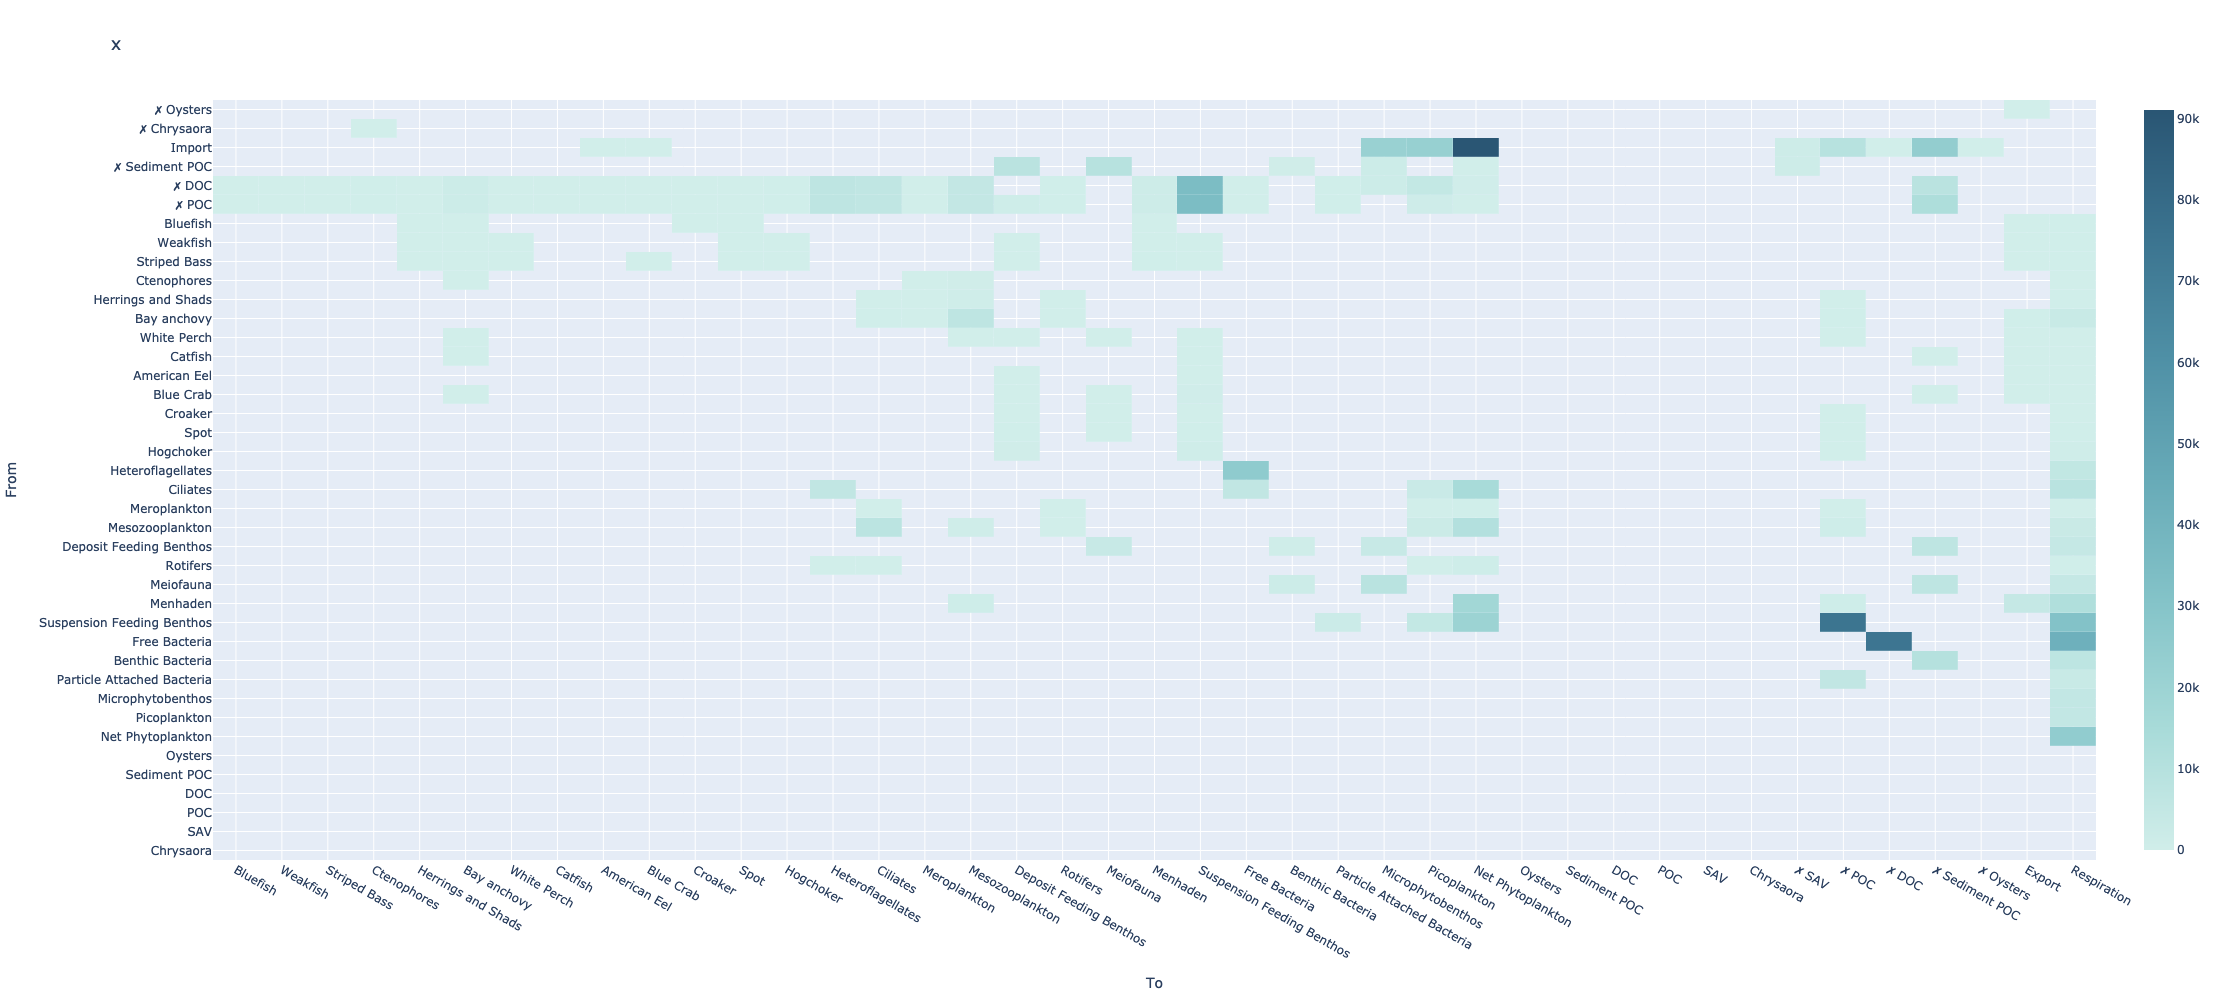

In [242]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Heatmap(
        z=[x['weight'] for x in flows[2]],
        x=flows[0],
        y=flows[1],
        xgap =	0.2,
        ygap =	0.2,
        colorscale='Teal',
    ))

order = x.nodeDF.sort_values(['IsAlive', 'TrophicLevel'])['Names'].unique()
yaxis={'categoryarray': order, 'title': 'From', 'zeroline':False, 'constraintoward': 'right', 'constrain': 'domain'}    
xaxis={'categoryarray': list(reversed(order)), 'title': 'To', 'zeroline':False, 'constraintoward': 'right', 'constrain': 'domain'}

fig.update_layout(title='x',  
                  width=1000, 
                  height=1000,
                  #autosize=True,
                  xaxis=xaxis,
                  yaxis=yaxis
                 )
fig.show()


In [244]:
x.flowMatrix.apply(lambda l: l> 0.0).values.sum()

158

In [253]:
exclude_nodes = ['Import', 'Export', 'Respiration']

graph_view = nx.restricted_view(x.graph, exclude_nodes, [])


print(x.graph.number_of_edges())
print(graph_view.number_of_edges())

254
158


In [257]:
x.getFlowMatWithBoundary().sum()

Net Phytoplankton             1.159826e+05
Weakfish                      7.542160e+02
Bluefish                      7.880720e+02
Striped Bass                  7.167720e+02
Catfish                       2.450880e+02
American Eel                  6.357200e+01
Hogchoker                     2.088400e+03
Croaker                       2.322080e+02
Spot                          9.056480e+02
White Perch                   2.748960e+02
Herrings and Shads            9.845840e+02
Bay anchovy                   1.124525e+04
Menhaden                      3.625094e+04
Blue Crab                     1.018992e+03
Suspension Feeding Benthos    1.340359e+05
Meiofauna                     2.254000e+04
Picoplankton                  2.819064e+04
Free Bacteria                 1.170277e+05
Particle Attached Bacteria    9.472320e+03
Heteroflagellates             3.201434e+04
Ciliates                      3.916440e+04
Deposit Feeding Benthos       1.982490e+04
Meroplankton                  6.393080e+02
Rotifers   

In [248]:
self.getFlowMatWithBoundary().sum()


158

In [245]:
x.flowMatrix.apply(lambda l: l> 0.0)

Names,Net Phytoplankton,Weakfish,Bluefish,Striped Bass,Catfish,American Eel,Hogchoker,Croaker,Spot,White Perch,...,Ctenophores,Microphytobenthos,Benthic Bacteria,Mesozooplankton,Chrysaora,SAV,POC,DOC,Sediment POC,Oysters
Names,,,,,,,,,,,,,,,,,,,,,
Net Phytoplankton,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,True,True,False
Weakfish,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Bluefish,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Striped Bass,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Catfish,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
American Eel,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Hogchoker,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Croaker,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
Spot,False,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
